# Logistic Regression with uni, bi, and tri gram embeddings

## imports

In [2]:
import string
from os import listdir
from os.path import isfile, join
import nltk
from nltk import word_tokenize
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer


# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from sklearn.model_selection import train_test_split

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

nltk.download('opinion_lexicon')
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dylanedwards/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### configs

In [3]:
train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 350

destination_folder = "./data"

### setup puncuation and contractions to help clean text

In [4]:
punctuation = string.punctuation
positive_dict = set(opinion_lexicon.positive())
negative_dict = set(opinion_lexicon.negative())
positive_dict_stemmed = [PorterStemmer().stem(word) for word in positive_dict]
negative_dict_stemmed = [PorterStemmer().stem(word) for word in negative_dict]

contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

### functions to help get data from txt files and to process and clean data

In [5]:
def get_file_key(fileName):
    # get the file num
    return int(fileName.split("_")[1].split(".")[0]) 
    
def get_files_from_dir(directory):
    filesInDir = [f for f in listdir(directory) if isfile(join(directory, f))]
    return sorted(filesInDir, key = get_file_key)   
        
def process_string_sentence(text):
        englishStopwords = stopwords.words("english")  # non-neccesary words
        text = text.lower()  # case folding
        # remove punctuation
        text = "".join([char for char in text if char not in punctuation])
        words = word_tokenize(text)
        removed = [word for word in words if word not in englishStopwords]
        stemmed = [PorterStemmer().stem(word) for word in removed]
        stemmed_sentence = " ".join(stemmed)
        return stemmed_sentence

def process_string(text):
        englishStopwords = stopwords.words("english")  # non-neccesary words
        text = text.lower()  # case folding
        # remove punctuation
        text = "".join([char for char in text if char not in punctuation])
        words = word_tokenize(text)
        removed = [word for word in words if word not in englishStopwords]
        return [", ".join(removed)]


def tokenize_files(files, dir):
        cleaned_positive_files = []
        for file in files:
            file_path = str.format("{}/{}", dir, file)
            with open(file_path) as f:
                raw_text = f.read()
                cleaned_positive_files.append(process_string(raw_text))
        return cleaned_positive_files

def is_word_positive(word):
        if word in positive_dict or word in positive_dict_stemmed:
            return True
        return False

def is_word_negative(word):
    if word in negative_dict or word in negative_dict_stemmed:
        return True
    return False



def get_word_occurrences(tokenized_files):
        word_occurrences = {}
        word_occurrences["positive"] = 0
        word_occurrences["negative"] = 0
        total_num_words = 0
        for file in tokenized_files:
            # calc number exclams
            # calc number pos/neg/words
            for word in file:
                if is_word_positive(word):
                    word_occurrences["positive"] += 1
                if is_word_negative(word):
                    word_occurrences["negative"] += 1
                if word not in word_occurrences:
                    word_occurrences[word] = 0
                word_occurrences[word] += 1
                total_num_words += 1
        return word_occurrences, total_num_words

def get_raw_text_from_files(files: list, dir: str) -> list:
    raw_text = []
    for file in files:
        file_path = str.format("{}/{}", dir, file)
        with open(file_path) as f:
            file_text_in_lines = f.read()
            raw_text.append(file_text_in_lines)
    return raw_text

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''

    # Convert words to lower case
    text = text.lower()

    # Replace contractions with their longer forms
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)

    return text


### import and process the data

In [6]:
df = pd.read_csv("./data/raw_train.csv")

In [7]:
dataSample = df.sample(n = 10000)

In [8]:

dataSample['All_Labels'] = (dataSample['OpenStatus'] == 'open').astype('int')
dataSample['titletext'] = dataSample['Title'] + ". " + dataSample['BodyMarkdown']

### gather and clean data 

In [9]:
# neg_data = np.array(get_raw_text_from_files(get_files_from_dir("./data/neg"), "data/neg"))
# pos_data = np.array(get_raw_text_from_files(get_files_from_dir("./data/pos"), "data/pos"))
# allData = np.concatenate((neg_data, pos_data))
# # making labels for the data, the first
# neg_labels = np.fromiter([0 for i in range(len(neg_data))], int)  # create negative labels
# pos_labels = np.fromiter([1 for i in range(len(pos_data))], int)  # create positive labels
# allLabels = np.concatenate((neg_labels, pos_labels))

dataSample['Titles_Cleaned'] = list(map(clean_text, dataSample["Title"]))
dataSample['Bodies_Cleaned'] = list(map(clean_text, dataSample["BodyMarkdown"]))
dataSample['Title_Text_Cleaned'] = list(map(clean_text, dataSample["titletext"]))


In [10]:
# # allLabels = np.concatenate((neg_labels, pos_labels))
# dataSample['All_Labels'] = list(dataSample['OpenStatus'] == "open")
# dataSample['All_Labels'] = dataSample['All_Labels'].astype(int)

In [11]:
df

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,4,07/31/2008 21:42:52,8,07/31/2008 21:33:24,1,0,Decimal vs Double?,"I'm new to C#, and I want to use a trackbar fo...",c#,NaN,NaN,NaN,NaN,NaN,open
1,6,07/31/2008 22:08:08,9,07/31/2008 21:35:26,1,0,Percentage width child in absolutely positione...,I've got an absolutely positioned div containi...,html,css,NaN,NaN,NaN,NaN,open
2,8,07/31/2008 23:33:19,9,07/31/2008 21:35:26,16,1,Tools for porting J# code to C#,Are there any conversion tools for porting Vis...,j#,NaN,NaN,NaN,NaN,NaN,open
3,9,07/31/2008 23:40:59,1,07/31/2008 14:22:31,1,1,How do I calculate someone's age in c#?,"Given a DateTime representing their birthday, ...",c#,NaN,NaN,NaN,NaN,NaN,open
4,9610539,03/07/2012 23:07:09,1021610,10/31/2011 08:26:49,29,0,retrieve data from NSUserDefaults to TableView,I save values of two labels through NSUserDefa...,iphone,objective-c,ios5,NaN,NaN,NaN,open
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3370523,11731072,07/30/2012 23:22:05,996334,10/15/2011 00:02:23,166,0,Dividing an array by filter function,I have a Javascript array that I would like to...,javascript,NaN,NaN,NaN,NaN,NaN,open
3370524,11731048,07/30/2012 23:19:10,216857,11/23/2009 08:56:56,431,5,JavaScript Link Extractor,I am interested in extracting links from sites...,javascript,hyperlink,extract,crawl,NaN,NaN,open
3370525,11731091,07/30/2012 23:24:49,1564321,07/30/2012 23:11:04,1,0,Selenium Remote Webdriver insane memory usage,I've created a small python script to run test...,selenium,python-2.7,selenium-rc,selenium2,NaN,NaN,open
3370526,11731092,07/30/2012 23:24:50,1432894,06/02/2012 21:23:55,75,8,Searching through an array of dictionaries,I'm making an iPhone app which displays inform...,iphone,objective-c,xcode,search,nsmutablearray,NaN,open


### function to run logistic regression model with the given bow converter and data

In [12]:
def run_logisitc(allData, allLabels, description,  bow_converter, _C=1.0,):
    kf = KFold(n_splits=5, shuffle=True)
    for trainingIndex, testingIndex in kf.split(allData):
        # get the train/test labels and data from split
        trainingData, testingData = allData[trainingIndex], allData[testingIndex]
        trainingLabels, testingLabels = allLabels[trainingIndex], allLabels[testingIndex]

        # convert the data to bow
        trainingData = bow_converter.fit_transform(trainingData)
        testingData = bow_converter.transform(testingData)

        # create the model
        model = LogisticRegression(C=1.0, max_iter=1000).fit(trainingData, trainingLabels)

        # get the model score
        score = model.score(testingData, testingLabels)
        print(description, " model score: ", score)

        # get label prediction
        labelPrediction = model.predict_proba(testingData)[:, 1]

        # use prediction to get metrics
        precision, recall, thresholds = precision_recall_curve(testingLabels, labelPrediction)
        average_precision = average_precision_score(testingLabels, labelPrediction)

        # plot curve
        disp = plot_precision_recall_curve(model, testingData, testingLabels)
        disp.ax_.set_title('2-class Precision-Recall curve: '
                        'AP={0:0.2f}'.format(average_precision))




In [14]:
# turn into numpy array 
allLabels = np.array(dataSample['All_Labels'])
allLabels.size

10000

In [15]:
# turn into numpy array 
titlesAndText = np.array(dataSample['Title_Text_Cleaned'])
titlesAndText.size

10000

bigram BOW  model score:  0.9725


/Users/dylanedwards/Desktop/oxy-nlp/final-project/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


bigram BOW  model score:  0.978


/Users/dylanedwards/Desktop/oxy-nlp/final-project/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


bigram BOW  model score:  0.972


/Users/dylanedwards/Desktop/oxy-nlp/final-project/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


bigram BOW  model score:  0.9795


/Users/dylanedwards/Desktop/oxy-nlp/final-project/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


bigram BOW  model score:  0.9795


/Users/dylanedwards/Desktop/oxy-nlp/final-project/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


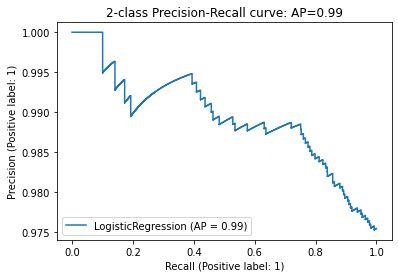

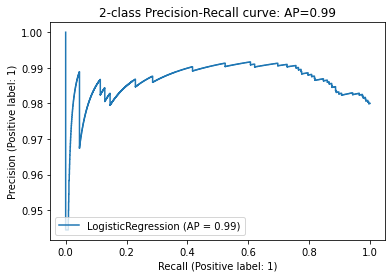

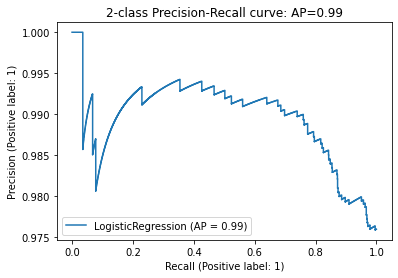

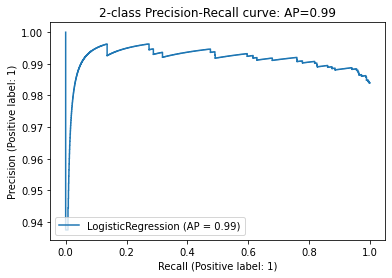

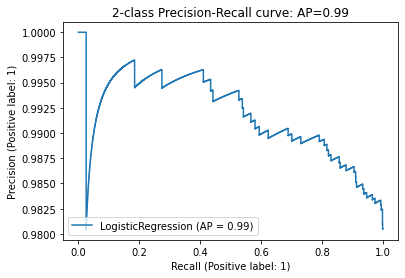

In [16]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False) 
run_logisitc(titlesAndText, allLabels, "bigram BOW", bigram_converter)